In [218]:
#pip install geopandas matplotlib

In [219]:
import geopandas as gpd
from shapely.geometry import Point
import requests
import json
import pandas as pd

#MERGED DF 1
pov_url = 'https://data.wprdc.org/dataset/c6265ffb-c86e-4a2c-870b-1aaa0772c449/resource/7996d143-c155-466e-8414-115f74997dd7/download/poverty-status-of-individuals-in-the-past-12-months-by-living-arrangement.csv';
pop_url = 'https://data.wprdc.org/dataset/95af9f2c-61c8-446b-ae72-852e195684f3/resource/a8414ed5-c50f-417e-bb67-82b734660da6/download/preliminarycitypittsburghneighborhood_pl94171summary-2.csv'
income_url = 'https://data.wprdc.org/dataset/c6265ffb-c86e-4a2c-870b-1aaa0772c449/resource/41d215a7-6baf-4de8-8593-d25c858d3546/download/aggregate-household-income-in-the-past-12-months-in-2014-inflation-adjusted-dollars.csv'
income = pd.read_csv(income_url)
poverty = pd.read_csv(pov_url)
population = pd.read_csv(pop_url)
poverty.rename(columns={'Estimate; Income in the past 12 months below poverty level:': 'income_12mo_below_pov'}, inplace=True)
income.rename(columns={'Estimate; Aggregate household income in the past 12 months (in 2014 Inflation-adjusted dollars)': 'agg_income_past_12mo'}, inplace=True)

#MERGED DF 2 (THE GIS ONE)
food_url = 'https://data.wprdc.org/dataset/690409e3-27e2-47a1-beed-fd600097f951/resource/626357fa-c95d-465f-9a02-3121655b2b78/download/data-conveniencesupermarkets.csv'
food = pd.read_csv(food_url)
#Pittsburgh neighborhood locations
file_path = "C:/Users/Ben/Documents/School things/gn-pittsburgh.geojson"

with open(file_path, 'r') as f:
    data = json.load(f)

features = data['features']

In [204]:

neighborhoods = gpd.read_file(file_path)
crs = 'EPSG:4326' 

food_geo = [Point(xy) for xy in zip(food.Lon, food.Lat)]
geo_df = gpd.GeoDataFrame(food, crs=crs, geometry=food_geo)

In [205]:
stores_per_neighborhood = gpd.sjoin(neighborhoods, geo_df, how="left", op="contains")
stores_per_neighborhood = stores_per_neighborhood[['name', 'Category', 'geometry']]
stores_per_neighborhood.head()

B:\Anaconda\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,name,Category,geometry
0,South Side Flats,Convenience Store,"MULTIPOLYGON (((-79.97726 40.43273, -79.97725 ..."
0,South Side Flats,Supermarket,"MULTIPOLYGON (((-79.97726 40.43273, -79.97725 ..."
0,South Side Flats,Convenience Store,"MULTIPOLYGON (((-79.97726 40.43273, -79.97725 ..."
0,South Side Flats,Convenience Store,"MULTIPOLYGON (((-79.97726 40.43273, -79.97725 ..."
0,South Side Flats,Convenience Store,"MULTIPOLYGON (((-79.97726 40.43273, -79.97725 ..."


In [236]:
stores_per_neighborhood = gpd.sjoin(neighborhoods, geo_df, how="left", op="contains")

stores_per_neighborhood['weight'] = stores_per_neighborhood['Category'].apply(lambda x: 4 if x == 'Supermarket' else 1)

stores_count = stores_per_neighborhood.groupby('name').agg({'weight': 'sum', 'geometry': 'first'}).reset_index()

stores_count = stores_count.rename(columns={'weight': 'Food_Access'})

stores_count.head()


B:\Anaconda\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,name,Food_Access,geometry
0,Allegheny Center,1,"MULTIPOLYGON (((-80.00149 40.45269, -80.00146 ..."
1,Allegheny West,1,"MULTIPOLYGON (((-80.01457 40.45397, -80.01453 ..."
2,Allentown,1,"MULTIPOLYGON (((-79.99966 40.42812, -79.99960 ..."
3,Arlington,1,"MULTIPOLYGON (((-79.95773 40.41870, -79.95769 ..."
4,Arlington Heights,1,"MULTIPOLYGON (((-79.96027 40.41809, -79.96023 ..."


In [238]:
stores_count = stores_count.rename(columns={'name': 'Neighborhood', 'geometry': 'Geometry'})
stores_count.head(20)

,Neighborhood,Food_Access,Geometry
0,Allegheny Center,1,"MULTIPOLYGON (((-80.00149 40.45269, -80.00146 ..."
1,Allegheny West,1,"MULTIPOLYGON (((-80.01457 40.45397, -80.01453 ..."
2,Allentown,1,"MULTIPOLYGON (((-79.99966 40.42812, -79.99960 ..."
3,Arlington,1,"MULTIPOLYGON (((-79.95773 40.41870, -79.95769 ..."
4,Arlington Heights,1,"MULTIPOLYGON (((-79.96027 40.41809, -79.96023 ..."
5,Banksville,5,"MULTIPOLYGON (((-80.02969 40.42126, -80.02975 ..."
6,Bedford Dwellings,1,"MULTIPOLYGON (((-79.96568 40.45367, -79.96524 ..."
7,Beechview,5,"MULTIPOLYGON (((-80.02120 40.42342, -80.02110 ..."
8,Beltzhoover,2,"MULTIPOLYGON (((-79.99887 40.42173, -79.99853 ..."
9,Bloomfield,20,"MULTIPOLYGON (((-79.93938 40.46453, -79.93933 ..."


In [287]:
merged_df = pd.merge(income, poverty, on="Neighborhood", how='left')
merged_df = merged_df[["Neighborhood", "Estimate; Total:","income_12mo_below_pov"]]
merged_df.sort_values(by='income_12mo_below_pov').tail(50)

,Neighborhood,Estimate; Total:,income_12mo_below_pov
85,Upper Hill,1929.0,528.0
16,Central Business District,2655.0,533.0
50,Middle Hill,1675.0,545.0
8,Beltzhoover,1885.0,554.0
89,Westwood,3550.0,558.0
44,Larimer,1504.0,595.0
88,West Oakland,1317.0,623.0
61,Perry North,4062.0,645.0
17,Central Lawrenceville,4356.0,664.0
29,Elliott,2452.0,668.0


In [245]:
income_pov_food = pd.merge(merged_df, stores_count, on='Neighborhood', how='left')
income_pov_food.head()

,Neighborhood,Estimate; Total:,income_12mo_below_pov,Food_Access,Geometry
0,Allegheny Center,1130.0,516.0,1.0,"MULTIPOLYGON (((-80.00149 40.45269, -80.00146 ..."
1,Allegheny West,331.0,45.0,1.0,"MULTIPOLYGON (((-80.01457 40.45397, -80.01453 ..."
2,Allentown,2624.0,750.0,1.0,"MULTIPOLYGON (((-79.99966 40.42812, -79.99960 ..."
3,Arlington,1890.0,343.0,1.0,"MULTIPOLYGON (((-79.95773 40.41870, -79.95769 ..."
4,Arlington Heights,380.0,278.0,1.0,"MULTIPOLYGON (((-79.96027 40.41809, -79.96023 ..."


In [294]:
import numpy as np

income_pov_food = income_pov_food.rename(columns={'Estimate; Total:': 'Population', 'income_12mo_below_pov' : 'Pop. in Poverty'})
income_pov_food['% in Poverty'] = income_pov_food['Pop. in Poverty'] / income_pov_food['Population']
income_pov_food['Food_Per_Cap'] = income_pov_food['Food_Access'] / income_pov_food['Population']

income_pov_food['Poverty_Norm'] = (income_pov_food['% in Poverty'] - income_pov_food['% in Poverty'].min()) / (income_pov_food['% in Poverty'].max() - income_pov_food['% in Poverty'].min())

income_pov_food['Food_Per_Cap'] = income_pov_food['Food_Per_Cap'].replace([np.inf, -np.inf], np.nan)

income_pov_food['Food_Norm'] = (income_pov_food['Food_Per_Cap'] - income_pov_food['Food_Per_Cap'].min()) / (income_pov_food['Food_Per_Cap'].max() - income_pov_food['Food_Per_Cap'].min())

income_pov_food = income_pov_food[income_pov_food['Neighborhood'] != 'South Shore']
income_pov_food.reset_index(drop=True, inplace=True)


income_pov_food.sort_values('% in Poverty').head(40)

,Neighborhood,Population,Pop. in Poverty,Food_Access,Geometry,% in Poverty,Poverty_Norm,Food_Norm,Food_Per_Cap
81,Swisshelm Park,1286.0,51.0,1.0,"MULTIPOLYGON (((-79.89156 40.42673, -79.89200 ...",0.039658,0.000000,0.021082,0.000778
57,North Shore,187.0,8.0,1.0,"MULTIPOLYGON (((-79.99508 40.44999, -79.99535 ...",0.042781,0.004061,0.171703,0.005348
55,New Homestead,933.0,42.0,1.0,"MULTIPOLYGON (((-79.91815 40.39935, -79.91621 ...",0.045016,0.006967,0.030779,0.001072
79,Strip District,689.0,33.0,21.0,"MULTIPOLYGON (((-79.97494 40.45629, -79.97484 ...",0.047896,0.010712,1.000000,0.030479
5,Banksville,3944.0,252.0,5.0,"MULTIPOLYGON (((-80.02969 40.42126, -80.02975 ...",0.063895,0.031516,0.037237,0.001268
66,Regent Square,1009.0,67.0,1.0,"MULTIPOLYGON (((-79.89708 40.42764, -79.89661 ...",0.066402,0.034777,0.028118,0.000991
80,Summer Hill,1168.0,81.0,1.0,"MULTIPOLYGON (((-80.01086 40.50096, -80.01072 ...",0.069349,0.038609,0.023671,0.000856
63,Point Breeze,5333.0,442.0,1.0,"MULTIPOLYGON (((-79.89526 40.44716, -79.89516 ...",0.082880,0.056203,0.001633,0.000188
45,Lincoln Place,3465.0,293.0,3.0,"MULTIPOLYGON (((-79.91045 40.37846, -79.91042 ...",0.084560,0.058387,0.023989,0.000866
89,Windgap,1617.0,147.0,1.0,"MULTIPOLYGON (((-80.07321 40.45993, -80.07320 ...",0.090909,0.066643,0.015836,0.000618


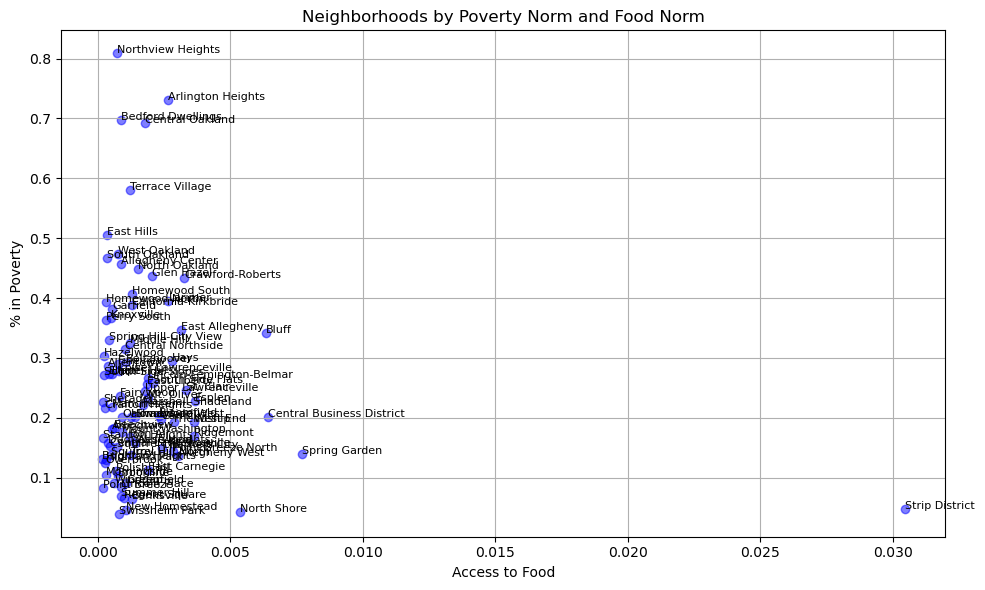

In [281]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(income_pov_food['Food_Per_Cap'], income_pov_food['% in Poverty'], c='blue', alpha=0.5)

plt.xlabel('Access to Food')
plt.ylabel('% in Poverty')
plt.title('Neighborhoods by Poverty Norm and Food Norm')

for i, txt in enumerate(income_pov_food['Neighborhood']):
    plt.annotate(txt, (income_pov_food['Food_Per_Cap'][i], income_pov_food['% in Poverty'][i]), fontsize=8)

plt.grid(True)
plt.tight_layout()
plt.show()
